In [1]:
# https://tinitaly.pi.ingv.it/
# https://data.ingv.it/dataset/185

In [2]:
import json
import os
import subprocess

import numpy as np

import requests

import pyproj as ppj
import rasterio

from PIL import Image

import matplotlib.pyplot as plt

from tqdm import tqdm

## Import GeoTIFF data

In [3]:
folder = "../data/tinitaly/"

In [4]:
names = [
    "w49030_s10.tif",
    "w49035_s10.tif",
    "w49530_s10.tif",
    "w49535_s10.tif",
]

unit = 10

chunks = []
for name in tqdm(names):
    path = folder + name

    # TODO handle y-axis orientation more consistently, as we swap again later...
    
    with rasterio.open(path) as dataset:
        heightmap = dataset.read(1)[::-1, :]

    # WGS 84 / UTM zone 32N
    # https://epsg.io/32632
    assert dataset.crs == 32632
    x = dataset.bounds.left
    y = dataset.bounds.bottom

    assert x % unit == 0
    assert y % unit == 0
    ix = int(x / unit)
    iy = int(y / unit)

    chunk = ix, iy, heightmap
    chunks.append(chunk)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.34it/s]


In [5]:
ix_min = min(ix for ix, _, _ in chunks)
iy_min = min(iy for _, iy, _ in chunks)
ix_max = max(ix + heightmap.shape[1] for ix, _, heightmap in chunks)
iy_max = max(iy + heightmap.shape[0] for _, iy, heightmap in chunks)
width = (ix_max - ix_min)
height = (iy_max - iy_min)
width, height

(8755, 10010)

In [6]:
buffer = np.full((height, width), np.nan)
for ix, iy, heightmap in chunks:
    h, w = heightmap.shape
    buffer[iy - iy_min : iy - iy_min + h, ix - ix_min : ix - ix_min + w] = heightmap

buffer = buffer[::-1].copy()

buffer[buffer < -1000] = np.nan

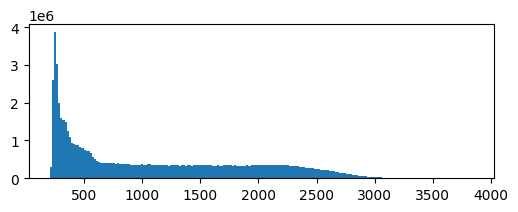

In [7]:
# Overall distribution of altitude data
_, ax = plt.subplots(figsize=(6, 2))
ax.hist(buffer.reshape(-1), bins=200)
plt.show()

In [8]:
# Conversion between WGS84 and LV95
WGS84 = ppj.CRS.from_epsg(4326)
WGS84_UTM_32N = ppj.CRS.from_epsg(32632)
wgs84_to_32n = ppj.Transformer.from_crs(WGS84, WGS84_UTM_32N, always_xy=True)

In [9]:
# Choose location, in WGS84
cy, cx = 44.6675, 7.091667

# Convert to zone
cx, cy = wgs84_to_32n.transform(cx, cy)
cx, cy

(348726.44850593654, 4947786.259553832)

In [10]:
# Moving center so that circle is in boundaries
cx += 700
cy -= 700

In [11]:
assert ix_min * unit <= cx < ix_max * unit
assert iy_min * unit <= cy < iy_max * unit

In [14]:
radius = 3000

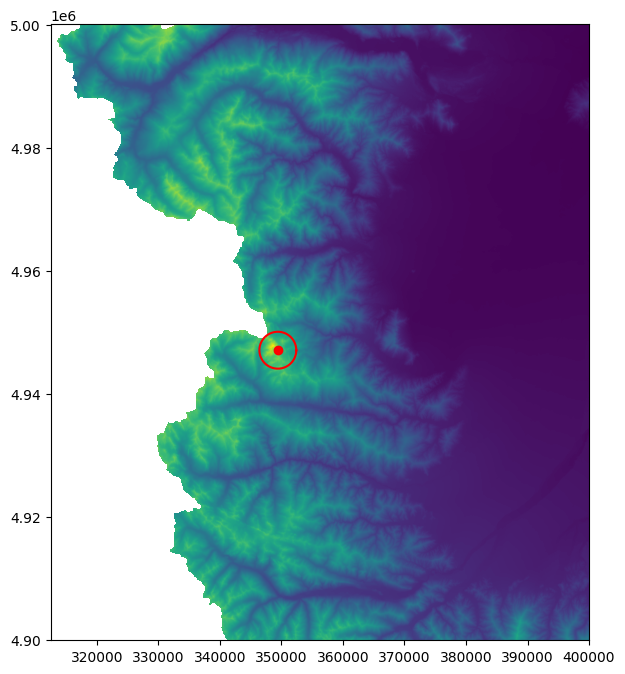

In [16]:
# Show heightmap
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(buffer, extent=(ix_min * unit, (ix_min + width) * unit, iy_min * unit, (iy_min + height) * unit))
ax.scatter([cx], [cy], c="r")
q = np.linspace(0.0, 2 * np.pi, 200, endpoint=True)
ax.plot(np.cos(q) * radius + cx, np.sin(q) * radius + cy, c="r")
ax.set_aspect("equal")
#ax.set_xlim(cx - 2000, cx + 2000)
#ax.set_ylim(cy - 2000, cy + 2000)
plt.show()

In [17]:
# Crop around circle of interest
left = int((cx - radius) / unit) - ix_min
right = int((cx + radius) / unit) - ix_min
bottom = height - int((cy - radius) / unit) + iy_min
top = height - int((cy + radius) / unit) + iy_min
right - left, bottom - top

(600, 600)

In [18]:
heightmap = buffer[top:bottom, left:right]

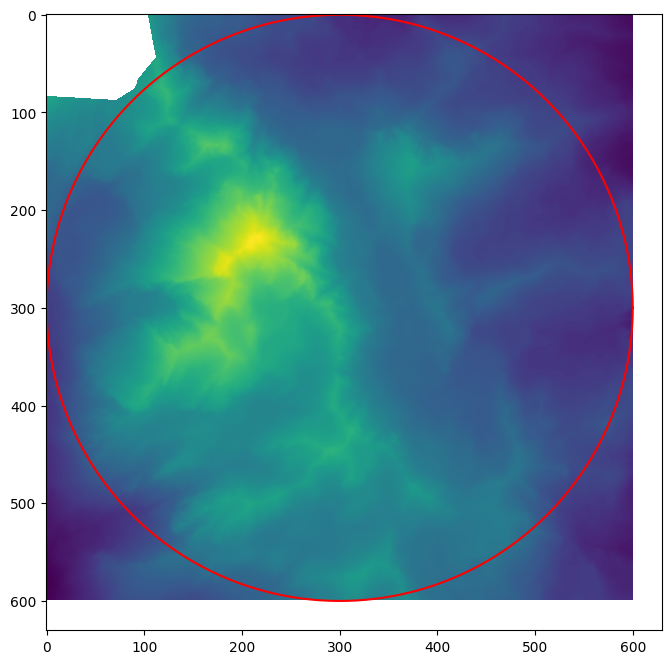

In [19]:
# Show heightmap
_, ax = plt.subplots(figsize=(8, 8))
ax.imshow(heightmap)
q = np.linspace(0.0, 2 * np.pi, 200, endpoint=True)
ax.plot((np.cos(q) + 1.0) * radius / unit, (np.sin(q) + 1.0) * radius / unit, c="r")
ax.set_aspect("equal")
plt.show()

## Generate 3D mesh

In [20]:
z_min = np.nanmin(heightmap)
z_max = np.nanmax(heightmap)
z_min, z_max

(1942.5870361328125, 3841.14111328125)

In [21]:
z_step = 20.0
z_base = z_min - z_step * 10
grid = heightmap.copy()
grid[np.isnan(grid)] = z_base + 10.0

In [22]:
import trimesh

In [39]:
h, w = grid.shape
scale = 0.01

vertices = []

for i in range(h):
    for j in range(w):
        vertices.append([j * unit, (h - i - 1) * unit, (grid[i, j] - z_base)])

perimeter = []
for i in range(h - 1):
    perimeter.append([0, i])
for j in range(w - 1):
    perimeter.append([j, h - 1])
for i in range(h - 1, 0, -1):
    perimeter.append([w - 1, i])
for j in range(w - 1, 0, -1):
    perimeter.append([j, 0])

for i, j in perimeter:
    vertices.append([j * unit, (h - i - 1) * unit, 0.0])

vertices.append([w / 2 * unit, h / 2 * unit, 0.0])

vertices = np.array(vertices) * scale

faces = []

for i in range(h - 1):
    for j in range(w - 1):
        faces.append([i * w + j, (i + 1) * w + j, i * w + j + 1])
        faces.append([i * w + j + 1, (i + 1) * w + j, (i + 1) * w + j + 1])

for k0 in range(len(perimeter)):
    k1 = (k0 + 1) % len(perimeter)
    i0, j0 = perimeter[k0]
    i1, j1 = perimeter[k1]
    faces.append([i1 * w + j1, h * w + k0, i0 * w + j0])
    faces.append([h * w + k1, h * w + k0, i1 * w + j1])
    faces.append([h * w + len(perimeter), h * w + k0, h * w + k1])

faces = np.array(faces)

In [40]:
mesh = trimesh.Trimesh(vertices, faces)

In [41]:
mesh.is_watertight

True

In [42]:
mesh.is_winding_consistent

True

In [43]:
cylinder = trimesh.creation.cylinder(
    radius=(h * unit - 1.0) * scale / 2,
    height=(z_max - z_base + 100) * scale * 2,
    sections=2000,
    transform=trimesh.transformations.translation_matrix([w * unit * scale / 2, h * unit * scale / 2, 0.0]),
)

In [44]:
output = trimesh.boolean.intersection([mesh, cylinder])

In [45]:
output.is_watertight

True

In [46]:
output.is_winding_consistent

True

In [47]:
output.export("mesh.stl");

## Export layers as BMP

In [ ]:
# Create new folder for temporary files
folder = "../data/tmp/"
assert not os.path.exists(folder)
os.mkdir(folder)

In [163]:
# Thickness of each layer
z_step = 20.0
z_transition = 1.0

# Actual altitude range
z_min = np.nanmin(heightmap)
z_max = np.nanmax(heightmap)

# From this point, slice regularly
# Note: make sure we start just above the lowest point
zs = np.arange(z_min + z_step, z_max, z_step)

z_min, z_max, len(zs)

(1942.5870361328125, 3841.14111328125, 94)

In [164]:
# Make sure we did not mess up the circle thing
assert heightmap.shape[0] == heightmap.shape[1]

In [165]:
# Print layer thickness in mm
print_thickness = 0.5

# A single unit (i.e. pixel) in print size (i.e. mm)
unit * print_thickness / z_step

0.25

In [185]:
# 20 meters is 0.5mm, vertically
# Currently implemented as 0.33mm in Fusion script
print(0.5 / 0.33)

# 6000m is 60mm
# 20 meters is 0.2mm, horizontally
print(0.2 / 0.5)

# Layer thickness: 0.25 x 2
# Scale X: 250
# Scale Y: 250
# Scale Z: 151.52

# Layer thickness: 0.25
# Scale X: 125
# Scale Y: 125
# Scale Z: 75.76

# Layer thickness: 0.2 x 2
# Scale X: 200
# Scale Y: 200
# Scale Z: 121.21

1.5151515151515151
0.4


In [186]:
1 / 0.4

2.5

In [181]:
125*1.6

200.0

In [178]:
0.5 / 0.2

2.5

In [182]:
0.5 / 0.33 / 2 * 1.6

1.2121212121212122

In [177]:
(20 / 0.5)

40.0

In [175]:
20 / 0.2

100.0

In [166]:
# Export grayscale image for each layer
for iz in tqdm(range(len(zs))):
    z = zs[iz]

    # Renormalize heightmap, so that z is at 0.5, and data is in [0.0, 1.0]
    h = np.tanh((heightmap - z) / z_transition)
    h = (0.5 - h * 0.5).clip(0.0, 1.0)
    h[np.isnan(h)] = 1.0

    # Convert to PIL image
    image = (h * 255).clip(0, 255).astype(np.uint8)
    image = Image.fromarray(image)

    # Export as BMP, which is one of the supported format of Potrace
    image.save(folder + f"{iz:04d}.bmp")

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 35.98it/s]


## Vectorize layers using Potrace

In [167]:
# Make sure you have installed Potrace!
# https://potrace.sourceforge.net/
POTRACE_PATH = "../potrace-1.16.win64/potrace.exe"

In [168]:
# Export as SVG (e.g. for Fusion 360)
for iz in tqdm(range(len(zs))):
    # TODO fine-tune
    args = [
        POTRACE_PATH,
        "-b",
        "svg",
        "-o",
        folder + f"{iz:04d}.svg",
        folder + f"{iz:04d}.bmp",
    ]
    result = subprocess.run(args)
    assert result.returncode == 0

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:04<00:00, 20.34it/s]
